# <span style="color:lightblue"><center><b>CLASSIFICAÇÃO DOS ESTÁGIOS DA CIRROSE</b></center></span>

Neste notebook vamos realizar  um processo de classificação de Estágio da cirrose utilizando o dataset que fizemos na análise exploratória posterior, com a intenção de explorar e classificar a coluna "Estágio", que indica qual o estágio atual da cirrose do paciente. Com isso, faremos a criação de modelos de Regressão Linear, Árvore de Decisão e Redes Neurais para identificar o estágio atual da cirrose de um determinado paciente, com base nos dados de input, visando a melhor acurácia possível nos modelos.

---
### **Importando as Bibliotecas e Definindo Funções**
---


In [1]:
import pandas as pd # Manipulação de Tabelas
import matplotlib.pyplot as plt # Visualização de Dados
import numpy as np # Operações matemáticas
from matplotlib.colors import LinearSegmentedColormap # Manipulação de paletas de cores
from seaborn import heatmap # Mapa de Calor

---
### **Importação dos Dados**
---

* Para treinar os modelos, usaremos o arquivo csv "liver_cirrhosis_v2", que foi o arquivo previamente separado na etapa de limpeza de dados, removendo boa parte das variáveis do Dataframe e deixando apenas as mais importantes para a classificação dos estágios da cirrose.


In [2]:
df = pd.read_csv('../data/dados_processados/liver_cirrhosis_v2.csv')
df['Estágio'] = pd.factorize(df['Estágio'])[0]
df.head()

,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,18499,F,N,S,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,19724,M,S,N,S,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,21699,F,N,S,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


* Porém, como alguns dados categóricos se encontram em formato de texto, iremos fazer o tratamento desses dados.

In [3]:
categoric_columns = list(df.select_dtypes(include=['object']).columns)

df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,F,N,S,N,N
1,M,S,N,S,N
2,F,N,N,N,N
3,F,N,N,N,N
4,F,N,S,N,N


---
### **Transformando os Dados de Categóricos para Numéricos**
---
* Sabemos que modelos de machine learning não se dão bem com dados categóricos em formato de string, que é o caso, e por isso vamos usar o método "pd.factorize( )" do pandas, que é usado para codificar valores de uma série ou coluna em números inteiros, transformando as classes de strings para int. Isso permitirá usarmos os dados no modelos de regressão logística;
* Após essa transformação, iremos substituir esses valores no dataframe.

In [4]:
colunas_binarias = {column:pd.factorize(df[column])[0] for column in df[categoric_columns].columns}
df[categoric_columns] = pd.DataFrame(colunas_binarias)
df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


Como na coluna 'Sexo' o valor M (Masculino) tornou-se 1, iremos mudar o nome da coluna 'Sexo' para 'Sexo Masculino', onde 1 indicará o Sexo Masculino, e 0 indicará o Sexo Feminino. 

In [5]:
df.rename(
    columns={'Sexo':'Sexo Masculino'}, # Mudando 'Sexo' para 'Sexo Masculino', 
    inplace=True # Realiza a mudança no prórprio df
)

# Atualizando a lista de colunas categóricas
categoric_columns.remove('Sexo')
categoric_columns.insert(0,'Sexo Masculino')

df[categoric_columns].head()

,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


#### **Transformando a Idade de Dias para Anos**
* Isso é pra uma questão mais prática, além de percebermos uma certa clareza no heatmap quando estávamos comparando com a idade em dias

In [6]:
df['Idade'] = (df['Idade']/365).astype(int)
df.head()

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,50,0,0,0,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,54,1,1,1,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,32,0,0,1,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,45,0,0,1,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,59,0,0,0,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


---
### **Plotando o Mapa de Calor para Analisarmos as Correlações**
---
* Iremos analisar as correlações das variáveis numéricas com os dados previamente separados

In [7]:
# Gerar uma máscara para a metade superior e criar um mapa triangular
half_mask = np.triu(np.ones_like(df.corr(), dtype=bool))

<Axes: >

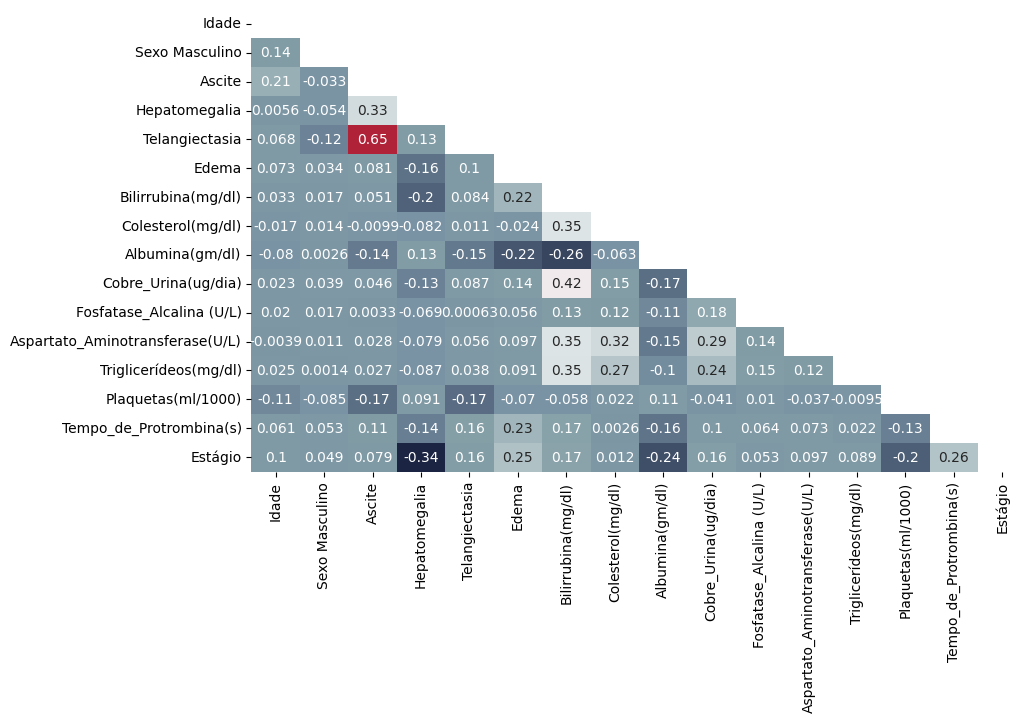

In [8]:
# Mapa de calor com as correlações
colors = ["#1b2442","#7992a4","#829da5","#f4f7f7","#b02238"]
cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)
plt.figure(figsize=[10,6])
heatmap(df.corr(),
        mask=half_mask, 
        annot=True, # Escreve os valores dos coeficientes
        cmap=cmap, # Paleta de cores
        cbar=False,
)

#### **Filtando os índices de correlação que possui módulo > 0.10**


In [9]:
mask = df.corr().abs() >+ 0.1
filtered = df.corr().where(mask)
filtered

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
Idade,1.000000,0.138954,0.205923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112695,NaN,NaN
Sexo Masculino,0.138954,1.000000,NaN,NaN,-0.124024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascite,0.205923,NaN,1.000000,0.329621,0.649646,NaN,NaN,NaN,-0.143593,NaN,NaN,NaN,NaN,-0.169384,0.114120,NaN
Hepatomegalia,NaN,NaN,0.329621,1.000000,0.132154,-0.161125,-0.196951,NaN,0.134408,-0.125755,NaN,NaN,NaN,NaN,-0.135294,-0.336901
Telangiectasia,NaN,-0.124024,0.649646,0.132154,1.000000,0.100366,NaN,NaN,-0.146398,NaN,NaN,NaN,NaN,-0.171288,0.163029,0.155757
Edema,NaN,NaN,NaN,-0.161125,0.100366,1.000000,0.224647,NaN,-0.224724,0.139269,NaN,NaN,NaN,NaN,0.225660,0.254994
Bilirrubina(mg/dl),NaN,NaN,NaN,-0.196951,NaN,0.224647,1.000000,0.352127,-0.261299,0.415027,0.132425,0.352460,0.348504,NaN,0.170697,0.172219
Colesterol(mg/dl),NaN,NaN,NaN,NaN,NaN,NaN,0.352127,1.000000,NaN,0.145983,0.117626,0.322665,0.267340,NaN,NaN,NaN
Albumina(gm/dl),NaN,NaN,-0.143593,0.134408,-0.146398,-0.224724,-0.261299,NaN,1.000000,-0.168683,-0.112587,-0.147348,-0.103031,0.107514,-0.156307,-0.237199
Cobre_Urina(ug/dia),NaN,NaN,NaN,-0.125755,NaN,0.139269,0.415027,0.145983,-0.168683,1.000000,0.184010,0.285076,0.239766,NaN,0.101950,0.160070


<Axes: >

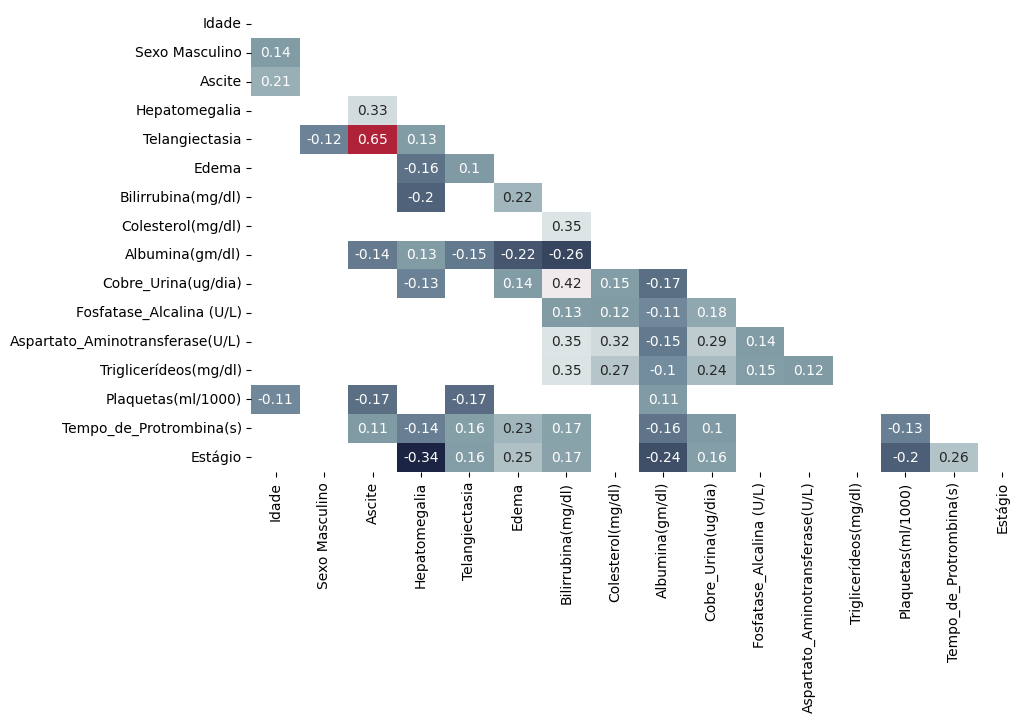

In [10]:
# Mapa de calor com as correlações cujo módulo >= 10
plt.figure(figsize=[10,6])
heatmap(
    filtered,
    mask=half_mask, 
    annot=True, # Escreve os valores dos coeficientes
    cmap=cmap, # Paleta de cores
    cbar=False
)

Perceba que Telangiectasia apresentou uma correlação positiva moderada quase forte com Ascite. Isso pode ser explicado pois: 

'Em geral, pacientes com hepatopatia e ascite apresentam outros estigmas de doença hepática, como presença de telangiectasias[...]'

> Disponível em: [Ascite no paciente cirrótico](https://www.medicinanet.com.br/conteudos/revisoes/5464/ascite_no_paciente_cirrotico.htm)

---
## **Desenvolvendo o Modelo**
---

#### **Importando Bibliotecas para Fazer o Modelo**

In [7]:
from sklearn.model_selection import train_test_split # Separação de dados de treino e teste
from sklearn.linear_model import LogisticRegression # Modelo de Regressão Logística
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # Feedback do modelo, matriz de confusão
from sklearn.preprocessing import StandardScaler # Padronizador de Dados
from joblib import dump # Salvar modelos

#### **Separação de Dados de Treino e Teste**

* Agora que os dados foram devidamente transformados, vamos separar nossa base de dados em conjuntos de treino e teste. Para isso, utilizamos o método `train_test_split` do scikit-learn:

* A princípio, iremos separar os dados entre as variáveis **preditoras** _(variáveis utilizadas para prever algo: X)_, e a variável **alvo** _(variável a ser prevista: Y)_. Nesse caso, vamos dividir 80% dos dados para treino e 20% para teste.


In [9]:
# Obtendo as variáveis x e y para treinar o modelo 
X = df.drop(columns=['Estágio']).values
Y = df['Estágio'].values 

# Dividindo 80% dos dados para treinar o modelo e 20% para os testes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print("Tamanho separado para treinos: " + str(len(X_train)))
print("Tamanho separado para testes: " + str(len(X_test)) + "\n")

print(X)
print(Y)

Tamanho separado para treinos: 7709
Tamanho separado para testes: 1928

[[ 50.    0.    0.  ...  57.  256.    9.9]
 [ 54.    1.    1.  ...  75.  220.   10.8]
 [ 32.    0.    0.  ...  80.  225.   10. ]
 ...
 [ 67.    0.    0.  ...  84.  412.   11.8]
 [ 58.    0.    0.  ...  90.  228.   10.3]
 [ 78.    1.    1.  ...  99.   97.   11.2]]
[0 1 1 ... 2 1 2]


#### **Normalizando os Dados**
* Nessa etapa, iremos realizar a padronização dos dados. A padronização dos dados é um passo importante no pré-processamento para muitos algoritmos de machine learning. O objetivo da padronização é transformar os dados para que tenham uma média zero e um desvio padrão de um. 

* No código abaixo, utilizamos `StandardScaler` do scikit-learn para padronizar nossos dados de treino e teste:

In [10]:
# Normalizando as variáveis preditoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

# Salvando o scaler para uso futuro
print("O normalizador 'scaler' foi salvo em:")
dump(scaler, 'scalers/stage_scaler.joblib')

O normalizador 'scaler' foi salvo em:


['scalers/stage_scaler.joblib']

---
## **Regressão Logística**
---

* Nosso primeiro modelo de classificação será feito utilizando Regressão Logística. Vamos utilizar o objeto **Logistic Regression** e dar um *fit()* para poder treinar nosso modelo, e depois salvar a predição numa variável separada. Os resultados da regressão são exibidos através de uma tabela de resultados, com a precisão de cada classe e acurácia geral, e também uma matriz de confusão com as 3 classes.


* Por fim, o modelo de Regressão Logística é salvo na pasta **models** no arquivo nomeado **stage_classifier.joblib** para que seja mais fácil de acessá-lo caso seja necessário.

In [14]:
# Instanciando o classificador
reg_classifier = LogisticRegression(max_iter=4000, n_jobs=-1)

# Treinando o modelo
reg_classifier.fit(X_train_scaled, y_train) # Treinando o modelo

# Realizando as predições
reg_test_predict = reg_classifier.predict(X_test_scaled) # Classe da predição

# Resultados do modelo
print(classification_report(y_test, reg_test_predict))

              precision    recall  f1-score   support

           1       0.47      0.53      0.50       609
           2       0.50      0.37      0.43       669
           3       0.63      0.73      0.68       650

    accuracy                           0.54      1928
   macro avg       0.53      0.54      0.53      1928
weighted avg       0.53      0.54      0.53      1928



O modelo atingiu apenas 54% de acurácia. Outros parâmetros foram testados, além da substituição e remoção de outras variáveis, mas devido a complexidade do problema, o modelo de Regressão Logística não é robusto o suficente. 

In [15]:
# Importância das classes para o modelo
coefficients_reg = reg_classifier.coef_
feature_importance_reg = pd.DataFrame(
    coefficients_reg.T, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=reg_classifier.classes_
    )
print("Importância das Variáveis (Coeficientes):\n")
print(feature_importance_reg)

Importância das Variáveis (Coeficientes):

                                        1         2         3
Idade                           -0.009659 -0.109275  0.118933
Sexo Masculino                  -0.037523  0.048621 -0.011098
Ascite                           0.010178 -0.161918  0.151740
Hepatomegalia                    0.464771  0.041281 -0.506052
Telangiectasia                  -0.189217  0.064828  0.124389
Edema                           -0.189829  0.003522  0.186307
Bilirrubina(mg/dl)               0.027210 -0.025678 -0.001532
Colesterol(mg/dl)                0.017054  0.111335 -0.128390
Albumina(gm/dl)                  0.084762  0.179730 -0.264492
Cobre_Urina(ug/dia)             -0.116814  0.030977  0.085837
Fosfatase_Alcalina (U/L)         0.018249 -0.002196 -0.016054
Aspartato_Aminotransferase(U/L) -0.061856  0.059933  0.001922
Triglicerídeos(mg/dl)           -0.094468  0.023796  0.070672
Plaquetas(ml/1000)               0.180203 -0.014918 -0.165285
Tempo_de_Protrombina(s)    

Interpretar os coeficientes de um modelo de regressão logística é fundamental para entender o impacto que cada variável possui probabilidade do evento alvo. Por exemplo, um coeficiente positivo indica que quanto maior ele for, maior será a probabilidade do evento acontecer. Caso seja negativo, indica o contrário.

Matriz de Confusão:
[[320 172 117]
 [262 250 157]
 [ 96  82 472]]


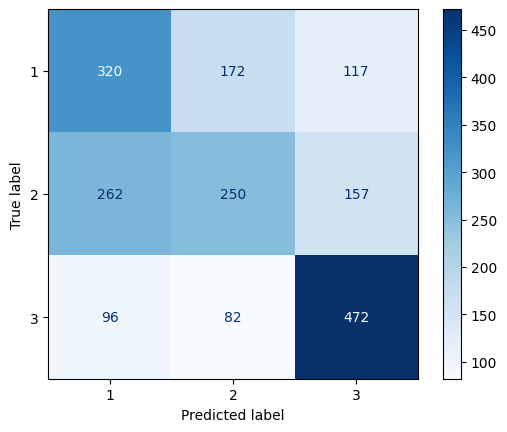

In [16]:
# Matriz de confusão
cm = confusion_matrix(y_test, reg_test_predict)

print("Matriz de Confusão:")
print(cm)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=reg_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
# Salvando o classifier para uso futuro
print("O modelo do scaler foi salvo em:")
dump(reg_classifier, 'models/stage_classifier.joblib')

O modelo do scaler foi salvo em:


['models/stage_classifier.joblib']

---
## **Árvore de Decisão**
---

* Agora vamos tentar outra alternativa de classificação. Dessa vez, vamos tentar utilizar o modelo 'Árvore de Decisão', que pode ser útil para nos ajudar a visualizar melhor o que está acontecendo no processo de classificação, e talvez até entregue resultados melhores na acurácia e precisão. 

* Perceba que podemos utilizar as mesmas variáveis X e Y, já que não foram modificadas.

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree # Modelo de Árvore de Decisão, plotagem da árvore

In [19]:
# Instanciando Árvore de decisão
arvore = DecisionTreeClassifier(
    random_state=42, 
    min_impurity_decrease=9.1e-05,
    )

O parâmetro min_impurity_decrease em uma árvore de decisão é um critério de parada que controla a criação de nós adicionais na árvore de decisão. Ele é usado para regular a complexidade da árvore, evitando o overfitting ao limitar a profundidade e o número de nós da árvore.

O valor passado foi encontrado com a análise da acurácia com base no aumento ou diminuição do parâmetro.

In [20]:
# Treinando o modelo
arvore.fit(X_train_scaled, y_train)

DecisionTreeClassifier(min_impurity_decrease=9.1e-05, random_state=42)

In [21]:
# Realizando as predições
arvore_predict = arvore.predict(X_test_scaled)

In [22]:
# Resultados do modelo
print(classification_report(y_test,arvore_predict))

              precision    recall  f1-score   support

           1       0.74      0.77      0.76       609
           2       0.75      0.72      0.74       669
           3       0.82      0.83      0.83       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



Perceba que o modelo de Árvore de Decisão já desenvolveu uma acurácia melhor do que o de Regressão Logística, apresentando 77% de acurácia.

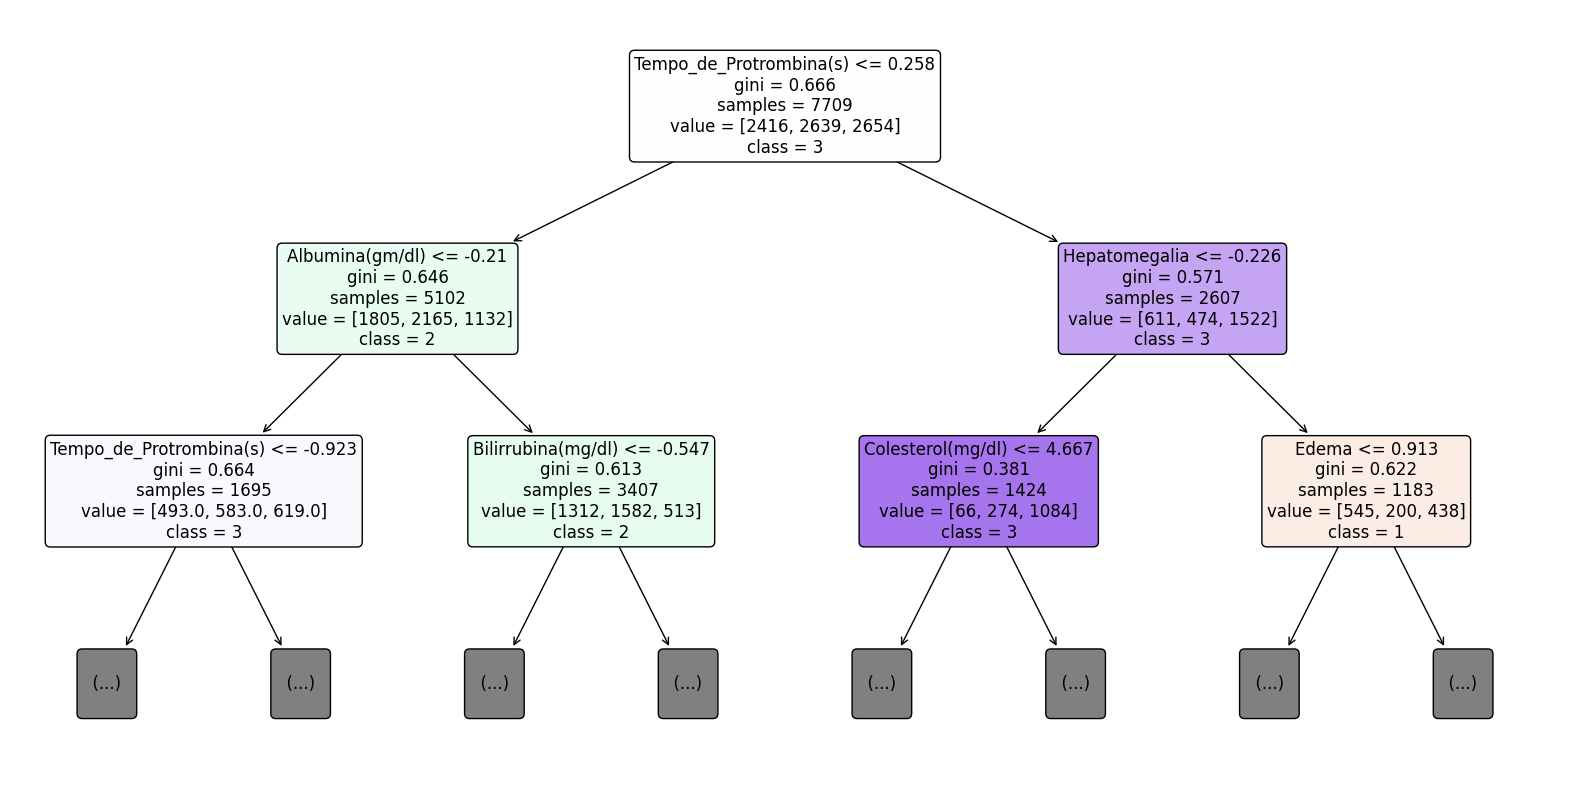

In [23]:
# Plotando a árvore
plt.figure(figsize=(20,10))
plot_tree(
    arvore, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2
    )
plt.show()

Agora vamos realizar um teste que consiste na predição dos dados de treino, para checar uma possibilidade de _overfitting_.

In [24]:
# Realizando as predições com os dados de treino para checar possibilidade de overfitting
arvore_predict_train = arvore.predict(X_train_scaled)

In [25]:
# Resultados dos dados de treino
print(classification_report(y_train, arvore_predict_train))

              precision    recall  f1-score   support

           1       0.97      0.96      0.97      2416
           2       0.97      0.97      0.97      2639
           3       0.98      0.98      0.98      2654

    accuracy                           0.97      7709
   macro avg       0.97      0.97      0.97      7709
weighted avg       0.97      0.97      0.97      7709



Perceba que o modelo apresentou quase 100% de acurácia com os dados de treino, o que pode ser um indicativo de _overfitting_. 

Para evitar isso, vamos realizar uma técnica chamada Grid Search para encontrar o melhor valor para o **ccp_alpha**, um parâmetro que nos ajuda a regularizar a árvore e evitar _overfitting_.

#### **Realizando o Grid Search**


In [26]:
from sklearn.model_selection import GridSearchCV # Algoritmo Grid Search

In [27]:
# Instanciando nova árvore
arvore_teste = DecisionTreeClassifier()

In [28]:
# Criando o caminho da poda de complexidade de custo
path = arvore_teste.cost_complexity_pruning_path(X_train_scaled, y_train)

In [29]:
# Realizando o Grid Search
param_grid = {'ccp_alpha': path.ccp_alphas}

CV_clf = GridSearchCV(
    estimator=arvore, 
    param_grid=param_grid, 
    cv = 7, 
    verbose=2, 
    n_jobs=-1
    )
CV_clf.fit(X_train, y_train)

Fitting 7 folds for each of 935 candidates, totalling 6545 fits


KeyboardInterrupt: 

* Com o valor em mãos, agora vamos criar outra árvore de decisão com os parâmetros modifiados, com o objetivo de verificar se há uma diferença na qualidade do modelo.

In [ ]:
# Atribuindo o ccp_aplha
ccp_alpha = CV_clf.best_estimator_.ccp_alpha

In [ ]:
# Instanciando uma nova árvore com o ccp_alpha
arvore_2 = DecisionTreeClassifier(
    random_state=42, 
    ccp_alpha=ccp_alpha,
    min_impurity_decrease=9.1e-05,
    )

In [ ]:
# Treinando a nova árvore
arvore_2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.00029186664937086524,
                       min_impurity_decrease=9.1e-05, random_state=42)

In [ ]:
# Realizando as novas predições
arvore_2_predict = arvore_2.predict(X_test_scaled)

In [ ]:
# Resultados do novo modelo
print(classification_report(y_test, arvore_2_predict))

              precision    recall  f1-score   support

           1       0.75      0.77      0.76       609
           2       0.75      0.73      0.74       669
           3       0.81      0.81      0.81       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



Não houve mudança significativa nos resultados do novo modelo.

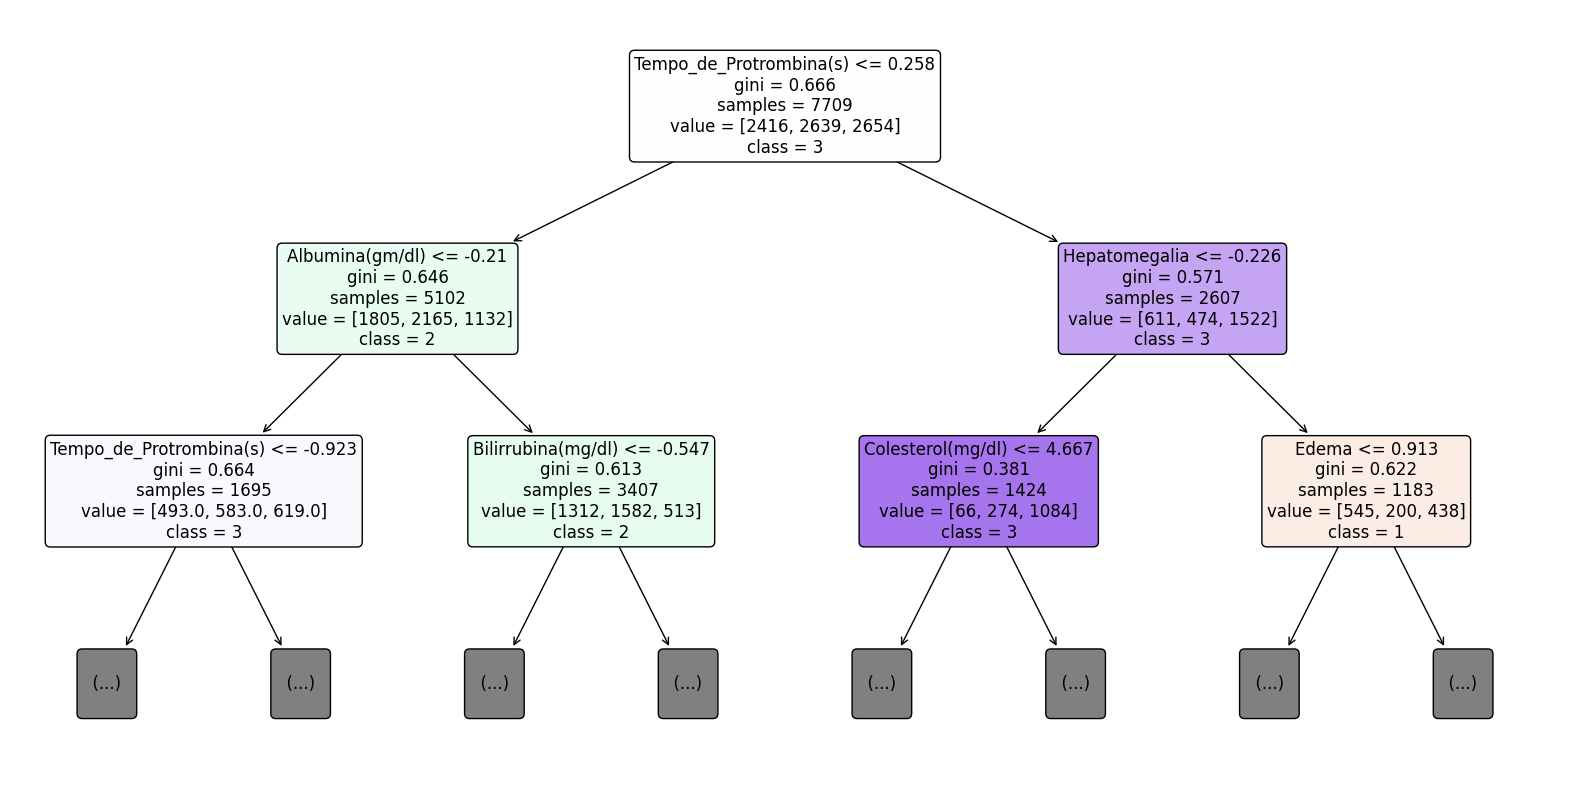

In [ ]:
# Plotando a nova árvore
plt.figure(figsize=(20,10))
plot_tree(
    arvore_2, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore_2.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2
    )
plt.show()

Agora, vamos realizar o mesmo procedimento feito com o primeiro modelo, que consiste em realizar as predições com os dados de treino, e comparar com os resultados anteriores.

In [ ]:
# Realizando predições dos dados de treino para comparar com os resultados
# de antes do Grid Search
arvore_2_predict_train = arvore_2.predict(X_train_scaled)

In [ ]:
# Resultados dos dados de treino
print(classification_report(y_train, arvore_2_predict_train))

              precision    recall  f1-score   support

           1       0.90      0.87      0.88      2416
           2       0.87      0.89      0.88      2639
           3       0.92      0.92      0.92      2654

    accuracy                           0.89      7709
   macro avg       0.89      0.89      0.89      7709
weighted avg       0.89      0.89      0.89      7709



Opa! Perceba que a acurácia com os dados de treino caiu para 89%, porém a acurácia com os dados de teste permaneceu a mesma. Isso indica que o modelo reduziu o fator de _overfitting_ sem prejudicar a acurácia com dados de teste.

In [ ]:
# Obter a importância das variáveis
importances = arvore_2.feature_importances_
feature_importance_tree = pd.DataFrame(
    importances, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=['Importance']
    ).sort_values(by='Importance', ascending=False)

print("Importância das Variáveis:\n")
print(feature_importance_tree)

Importância das Variáveis:

                                 Importance
Tempo_de_Protrombina(s)            0.205833
Albumina(gm/dl)                    0.176804
Plaquetas(ml/1000)                 0.144813
Hepatomegalia                      0.087253
Idade                              0.078663
Bilirrubina(mg/dl)                 0.068347
Cobre_Urina(ug/dia)                0.046128
Aspartato_Aminotransferase(U/L)    0.042780
Edema                              0.035620
Fosfatase_Alcalina (U/L)           0.033128
Triglicerídeos(mg/dl)              0.026029
Colesterol(mg/dl)                  0.022866
Telangiectasia                     0.018886
Ascite                             0.011008
Sexo Masculino                     0.001843


As variáveis estão ordenadas em ordem decrescente com base no quanto ela influencia o resultado de uma predição. As primeiras são as que mais influenciam e as últimas são as que não apresentam tanta influência, em termos de proporção.

Matriz de Confusão:
[[471  99  39]
 [ 98 490  81]
 [ 58  65 527]]


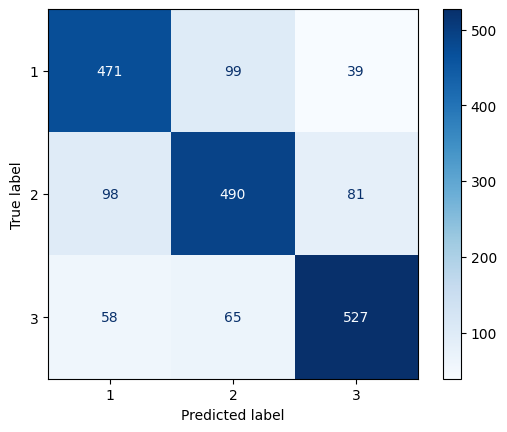

In [ ]:
# Matriz de confusão
cm_tree = confusion_matrix(y_test, arvore_2_predict)

print("Matriz de Confusão:")
print(cm_tree)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=arvore_2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Salvando o classifier para uso futuro
print("O modelo foi salvo em:")
dump(arvore_2, 'models/decision_tree.joblib')

O modelo do scaler foi salvo em:


['models/decision_tree.joblib']

In [10]:
from joblib import load

tree_clf = load('models/decision_tree.joblib')

s:\PYTHON\Virtual_Environments\AI_Tools\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
def extract_rules(sample_id, clf):
    x_sample = X_test_scaled[sample_id]

    #Id das features analisadas em cada nó da árvore de decisão
    feature = clf.tree_.feature

    #Limiar de decisão de cada nó da árvore
    threshold = clf.tree_.threshold

    #Acessa o caminho de nós da árvore até a folha de predicao da amostra
    node_indices = clf.decision_path([x_sample]).indices 
   
    #Último nó do caminho é a folha de predição
    leaf_id = node_indices[-1]
   
    print('\nFeatures usadas para predizer a amostra %s' % (sample_id))

    for f, v in zip(df.columns, x_sample):
        print('%s = %s'%(f,v))
    print('\n')      

    for node_id in node_indices:
        if leaf_id == node_id:
            break

        if (x_sample[feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("id do nó de decisão %s : (atributo %s com valor = %s %s %s)"
              % (node_id,
                 df.columns[feature[node_id]],
                 x_sample[feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
        
    pred = clf.predict([x_sample])

    print("\tClasse => %s" %pred)


extract_rules(10, tree_clf)


Features usadas para predizer a amostra 10
Idade = 1.0749320892630747
Sexo Masculino = -0.35272733014080143
Ascite = -0.718143059147346
Hepatomegalia = -1.2514971061324243
Telangiectasia = -0.9697150842262937
Edema = -0.44096831220689603
Bilirrubina(mg/dl) = -0.5361848361803512
Colesterol(mg/dl) = -0.013971259681600377
Albumina(gm/dl) = 0.8457772959300359
Cobre_Urina(ug/dia) = -0.5349773562193928
Fosfatase_Alcalina (U/L) = -0.3995321820547898
Aspartato_Aminotransferase(U/L) = -0.5187027908181501
Triglicerídeos(mg/dl) = 0.020145899894030015
Plaquetas(ml/1000) = -0.21814422790926816
Tempo_de_Protrombina(s) = 0.3117374997336632


id do nó de decisão 0 : (atributo Tempo_de_Protrombina(s) com valor = 0.3117374997336632 > 0.258035384118557)
id do nó de decisão 692 : (atributo Hepatomegalia com valor = -1.2514971061324243 <= -0.2262270748615265)
id do nó de decisão 693 : (atributo Colesterol(mg/dl) com valor = -0.013971259681600377 <= 4.666590213775635)
id do nó de decisão 694 : (atributo Al

REDE NEURAL

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [81]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

s:\PYTHON\Virtual_Environments\AI_Tools\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,283 (83.14 KB)

 Trainable params: 21,283 (83.14 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4200 - loss: 1.0533 - val_accuracy: 0.5228 - val_loss: 0.9130
Epoch 2/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.5068 - loss: 0.9551 - val_accuracy: 0.5524 - val_loss: 0.8874
Epoch 3/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5277 - loss: 0.9294 - val_accuracy: 0.5550 - val_loss: 0.8829
Epoch 4/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5497 - loss: 0.9173 - val_accuracy: 0.5617 - val_loss: 0.8636
Epoch 5/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5723 - loss: 0.8887 - val_accuracy: 0.5928 - val_loss: 0.8461
Epoch 6/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5582 - loss: 0.8819 - val_accuracy: 0.6058 - val_loss: 0.8233
Epoch 7/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5920 - loss: 0.8741 - val_accuracy: 0.6260 - val_loss: 0.8015
Epoch 8/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.6134 - loss: 0.8

In [85]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

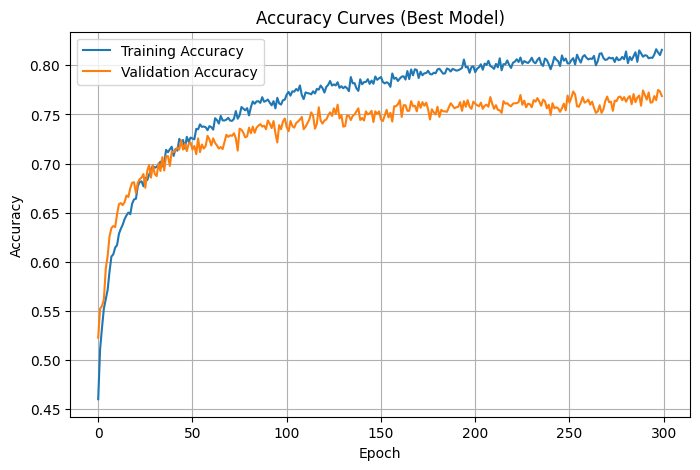

In [86]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

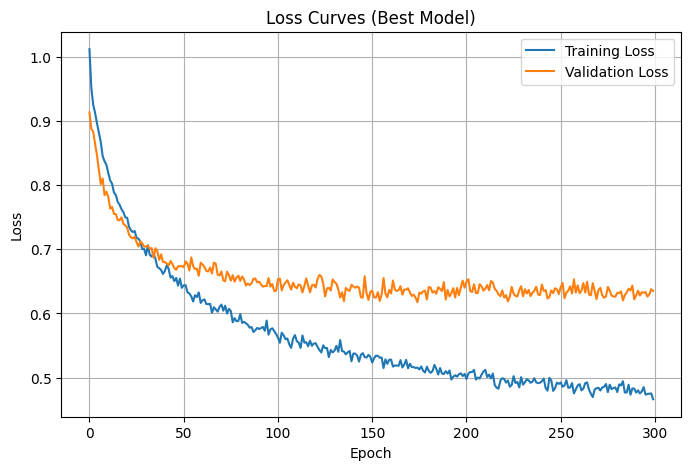

In [87]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [88]:
print(classification_report(y_test, np.argmax(model.predict(X_test_scaled), axis=1)))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       609
           1       0.71      0.75      0.73       669
           2       0.83      0.82      0.83       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928

